# CUSTOMER CHURN PREDICTION USING MACHINE LEARNING
# Bachelor's Thesis - Bank Churners Dataset

## 1. Introduction

This notebook implements customer churn prediction for a bank churners dataset.

### Methodology:
1. Data Loading & Exploration
2. Preprocessing & Feature Engineering
3. Model Training with Cross-Validation
4. Hyperparameter Tuning
5. Statistical Significance Testing
6. Feature Importance Analysis
7. Results & Conclusions

## 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from scipy.stats import wilcoxon
from itertools import combinations
import warnings

warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Libraries imported successfully')

Libraries imported successfully


## 3. Data Loading

In [2]:
# Load BankChurners dataset
df = pd.read_csv('../../BankChurners.csv')
target = 'Attrition_Flag'

# Drop unnecessary columns
# CLIENTNUM is just an ID
# Last two columns are Naive Bayes classifier outputs (not features)
df = df.drop(['CLIENTNUM',
              'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
              'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1)

print('Dataset Shape:', df.shape)
print('\nFirst 5 rows:')
print(df.head())
print('\nTarget Distribution:')
print(df[target].value_counts())

Dataset Shape: (10127, 20)

First 5 rows:
      Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F                4     High School   
4  Existing Customer            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3        Unknown  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0             

e## 4. Data Preprocessing

In [3]:
print('Missing Values:')
print(df.isnull().sum())

print('\nData types:')
print(df.dtypes)

Missing Values:
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

Data types:
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int6

## 5. Train-Test Split & Feature Engineering

In [4]:
# CRITICAL: Encode target BEFORE split (it's just the target, not a feature)
le_target = LabelEncoder()
df[target] = le_target.fit_transform(df[target])
print(f'Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}')

# CRITICAL: Split FIRST to prevent data leakage
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f'\nTraining set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')
print(f'\nClass distribution in training set:')
print(y_train.value_counts())
print(f'Imbalance ratio: {y_train.value_counts()[1]/y_train.value_counts()[0]:.2f}:1')

Target encoding: {'Attrited Customer': np.int64(0), 'Existing Customer': np.int64(1)}

Training set: 8101 samples
Test set: 2026 samples

Class distribution in training set:
Attrition_Flag
1    6799
0    1302
Name: count, dtype: int64
Imbalance ratio: 5.22:1


In [5]:
# Encode categorical features - fit on TRAINING data only
X_train = X_train.copy()
X_test = X_test.copy()

# Label encode Gender
le_gender = LabelEncoder()
X_train['Gender'] = le_gender.fit_transform(X_train['Gender'])
X_test['Gender'] = le_gender.transform(X_test['Gender'])

# One-hot encode categorical features
categorical_cols = ['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure test set has same columns as train set
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

extra_cols = set(X_test.columns) - set(X_train.columns)
for col in extra_cols:
    X_test = X_test.drop(columns=[col])

X_test = X_test[X_train.columns]

print('After encoding:')
print(X_train.head())
print(f'\nFeature count: {X_train.shape[1]}')

After encoding:
      Customer_Age  Gender  Dependent_count  Months_on_book  \
1602            54       0                3              49   
7791            51       1                0              45   
7177            45       0                4              29   
97              53       1                3              35   
4820            48       0                2              40   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
1602                         6                       2                      3   
7791                         3                       2                      3   
7177                         3                       2                      1   
97                           5                       3                      2   
4820                         3                       2                      4   

      Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  ...  \
1602       13184.0                    0          1318

In [6]:
# Feature Engineering - parameters computed on TRAINING data only

# Credit utilization efficiency
X_train['CreditUtilizationEfficiency'] = X_train['Total_Revolving_Bal'] / (X_train['Credit_Limit'] + 1e-6)
X_test['CreditUtilizationEfficiency'] = X_test['Total_Revolving_Bal'] / (X_test['Credit_Limit'] + 1e-6)

# Transaction intensity
X_train['TransactionIntensity'] = X_train['Total_Trans_Amt'] / (X_train['Total_Trans_Ct'] + 1e-6)
X_test['TransactionIntensity'] = X_test['Total_Trans_Amt'] / (X_test['Total_Trans_Ct'] + 1e-6)

# Relationship strength
X_train['RelationshipStrength'] = X_train['Total_Relationship_Count'] / (X_train['Months_on_book'] + 1)
X_test['RelationshipStrength'] = X_test['Total_Relationship_Count'] / (X_test['Months_on_book'] + 1)

# Activity ratio
X_train['ActivityRatio'] = (X_train['Months_on_book'] - X_train['Months_Inactive_12_mon']) / (X_train['Months_on_book'] + 1)
X_test['ActivityRatio'] = (X_test['Months_on_book'] - X_test['Months_Inactive_12_mon']) / (X_test['Months_on_book'] + 1)

# High value customer indicator (thresholds from TRAINING data)
credit_threshold = X_train['Credit_Limit'].median()
trans_threshold = X_train['Total_Trans_Amt'].median()

X_train['IsHighValue'] = (
    (X_train['Credit_Limit'] > credit_threshold) |
    (X_train['Total_Trans_Amt'] > trans_threshold)
).astype(int)

X_test['IsHighValue'] = (
    (X_test['Credit_Limit'] > credit_threshold) |
    (X_test['Total_Trans_Amt'] > trans_threshold)
).astype(int)

# Age group binning (quantiles from TRAINING data)
q33 = X_train['Customer_Age'].quantile(0.33)
q66 = X_train['Customer_Age'].quantile(0.66)
age_bins = [-np.inf, q33, q66, np.inf]

X_train['AgeGroup'] = pd.cut(X_train['Customer_Age'], bins=age_bins, labels=[0, 1, 2]).astype(int)
X_test['AgeGroup'] = pd.cut(X_test['Customer_Age'], bins=age_bins, labels=[0, 1, 2]).astype(int)

# Drop highly correlated features (correlation computed on TRAINING data only)
corr_matrix = X_train.corr()
high_corr = corr_matrix.abs() > 0.9
to_drop = set()
for i in range(len(high_corr.columns)):
    for j in range(i):
        if high_corr.iloc[i, j]:
            colname = high_corr.columns[i]
            to_drop.add(colname)

if len(to_drop) > 0:
    X_train = X_train.drop(columns=to_drop)
    X_test = X_test.drop(columns=to_drop)
    print(f'✓ Dropped highly correlated features: {to_drop}')
else:
    print('✓ No highly correlated features to drop')

print(f'\nFinal feature count: {X_train.shape[1]}')

✓ Dropped highly correlated features: {'TransactionIntensity', 'CreditUtilizationEfficiency', 'Avg_Open_To_Buy'}

Final feature count: 35


In [7]:
# Scaling - fit on TRAINING data only
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f'Scaled {len(numeric_cols)} columns')

Scaled 18 columns


## 6. Model Training with Cross-Validation

SMOTE is applied INSIDE each CV fold using ImbPipeline to prevent data leakage.

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

base_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(random_state=RANDOM_STATE),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
}

cv_results = {}

print('=' * 60)
print('CROSS-VALIDATION (SMOTE inside each fold)')
print('=' * 60)

for name, model in base_models.items():
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1)

    cv_results[name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }

    print(f'{name:25s}: F1 = {scores.mean():.4f} (+/-{scores.std():.4f})')

CROSS-VALIDATION (SMOTE inside each fold)
Logistic Regression      : F1 = 0.9265 (+/-0.0032)
Decision Tree            : F1 = 0.9533 (+/-0.0027)
k-Nearest Neighbors      : F1 = 0.9249 (+/-0.0077)
Naive Bayes              : F1 = 0.9073 (+/-0.0044)
Support Vector Machine   : F1 = 0.9567 (+/-0.0022)
XGBoost                  : F1 = 0.9807 (+/-0.0035)
LightGBM                 : F1 = 0.9817 (+/-0.0030)
CatBoost                 : F1 = 0.9834 (+/-0.0024)


In [9]:
cv_summary = pd.DataFrame({
    'Model': cv_results.keys(),
    'Mean F1': [cv_results[m]['mean'] for m in cv_results],
    'Std': [cv_results[m]['std'] for m in cv_results]
}).sort_values('Mean F1', ascending=False)

print('\n' + '=' * 60)
print('CV SUMMARY (Sorted by F1-Score)')
print('=' * 60)
print(cv_summary.to_string(index=False))


CV SUMMARY (Sorted by F1-Score)
                 Model  Mean F1      Std
              CatBoost 0.983399 0.002378
              LightGBM 0.981690 0.003013
               XGBoost 0.980690 0.003479
Support Vector Machine 0.956702 0.002236
         Decision Tree 0.953281 0.002685
   Logistic Regression 0.926526 0.003201
   k-Nearest Neighbors 0.924926 0.007737
           Naive Bayes 0.907295 0.004381


## 7. Hyperparameter Tuning

Tuning top 3 models. SMOTE is applied inside CV folds via ImbPipeline.

In [10]:
top_3_models = cv_summary.head(3)['Model'].tolist()
print(f'Top 3 models to tune: {top_3_models}')

Top 3 models to tune: ['CatBoost', 'LightGBM', 'XGBoost']


In [11]:
param_grids = {
    'LightGBM': {
        'classifier__num_leaves': [31, 50, 70],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__min_child_samples': [20, 30, 40]
    },
    'CatBoost': {
        'classifier__depth': [4, 6, 8],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__iterations': [100, 200, 300],
        'classifier__l2_leaf_reg': [1, 3, 5, 7]
    },
    'XGBoost': {
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.8, 0.9, 1.0]
    }
}

model_instances = {
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')
}

In [12]:
def tune_model(model_name, model, param_grid, X_train, y_train, n_iter=50):
    """Hyperparameter tuning with SMOTE inside CV folds."""
    print(f"\n{'=' * 60}")
    print(f'TUNING: {model_name}')
    print(f"{'=' * 60}")

    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=skf,
        scoring='f1',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )

    search.fit(X_train, y_train)

    print(f'\nBest CV F1-Score: {search.best_score_:.4f}')
    print('Best Parameters:')
    for param, value in search.best_params_.items():
        print(f'  {param}: {value}')

    return search.best_estimator_, search.best_params_, search.best_score_

In [13]:
tuned_models = {}
tuning_results = {}

for model_name in top_3_models:
    if model_name in param_grids:
        best_pipeline, best_params, best_score = tune_model(
            model_name,
            model_instances[model_name],
            param_grids[model_name],
            X_train, y_train
        )
        tuned_models[f'{model_name} (Tuned)'] = best_pipeline
        tuning_results[model_name] = {
            'best_params': best_params,
            'cv_score': best_score
        }


TUNING: CatBoost
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best CV F1-Score: 0.9846
Best Parameters:
  classifier__learning_rate: 0.1
  classifier__l2_leaf_reg: 1
  classifier__iterations: 300
  classifier__depth: 4

TUNING: LightGBM
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best CV F1-Score: 0.9821
Best Parameters:
  classifier__num_leaves: 31
  classifier__n_estimators: 300
  classifier__min_child_samples: 30
  classifier__learning_rate: 0.05

TUNING: XGBoost
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best CV F1-Score: 0.9831
Best Parameters:
  classifier__subsample: 0.8
  classifier__n_estimators: 300
  classifier__max_depth: 3
  classifier__learning_rate: 0.2
  classifier__colsample_bytree: 0.8


## 8. Model Evaluation on Test Set

In [14]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and return metrics."""
    y_pred = model.predict(X_test)

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

    return metrics, y_pred

In [15]:
print('=' * 60)
print('TEST SET EVALUATION')
print('=' * 60)

evaluation_results = []

for name, model in tuned_models.items():
    metrics, y_pred = evaluate_model(model, X_test, y_test, name)
    evaluation_results.append(metrics)

    print(f'\n{name}')
    print('-' * 40)
    print(f"Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall:    {metrics['Recall']:.4f}")
    print(f"F1-Score:  {metrics['F1-Score']:.4f}")
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

TEST SET EVALUATION

CatBoost (Tuned)
----------------------------------------
Accuracy:  0.9729
Precision: 0.9853
Recall:    0.9824
F1-Score:  0.9838

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       325
           1       0.99      0.98      0.98      1701

    accuracy                           0.97      2026
   macro avg       0.95      0.95      0.95      2026
weighted avg       0.97      0.97      0.97      2026

Confusion Matrix:
[[ 300   25]
 [  30 1671]]

LightGBM (Tuned)
----------------------------------------
Accuracy:  0.9748
Precision: 0.9870
Recall:    0.9830
F1-Score:  0.9850

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       325
           1       0.99      0.98      0.98      1701

    accuracy                           0.97      2026
   macro avg       0.95      0.96      0.95      2026
weighted avg       0.98   

In [16]:
results_df = pd.DataFrame(evaluation_results).sort_values('F1-Score', ascending=False)

print('\n' + '=' * 60)
print('RESULTS SUMMARY')
print('=' * 60)
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['F1-Score']
print(f'\nBest Model: {best_model_name} with F1-Score = {best_f1:.4f}')


RESULTS SUMMARY
           Model  Accuracy  Precision   Recall  F1-Score
 XGBoost (Tuned)  0.974827   0.985294 0.984715  0.985004
LightGBM (Tuned)  0.974827   0.987013 0.982951  0.984978
CatBoost (Tuned)  0.972853   0.985259 0.982363  0.983809

Best Model: XGBoost (Tuned) with F1-Score = 0.9850


## 9. Statistical Significance Testing

Wilcoxon signed-rank test to compare models.

In [17]:
print('Collecting CV scores for statistical testing...')

cv_scores_dict = {}
for name, model in tuned_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_scores_dict[name] = scores
    print(f'{name:25s}: {scores.mean():.4f} (+/-{scores.std():.4f})')

CatBoost (Tuned)         : 0.9846 (+/-0.0029)
LightGBM (Tuned)         : 0.9821 (+/-0.0022)
XGBoost (Tuned)          : 0.9831 (+/-0.0028)


In [18]:
def wilcoxon_test(scores_a, scores_b, name_a, name_b):
    """Wilcoxon signed-rank test between two models."""
    statistic, p_value = wilcoxon(scores_a, scores_b)

    diff = scores_a - scores_b
    cohens_d = np.mean(diff) / np.std(diff, ddof=1) if np.std(diff, ddof=1) > 0 else 0

    return {
        'Model A': name_a,
        'Model B': name_b,
        'Mean A': np.mean(scores_a),
        'Mean B': np.mean(scores_b),
        'p-value': p_value,
        "Cohen's d": cohens_d,
        'Significant': p_value < 0.05
    }

In [19]:
print('\n' + '=' * 60)
print('STATISTICAL SIGNIFICANCE TESTING')
print('=' * 60)

model_names = list(cv_scores_dict.keys())
comparisons = list(combinations(model_names, 2))

alpha = 0.05
corrected_alpha = alpha / len(comparisons) if len(comparisons) > 0 else alpha
print(f'Comparisons: {len(comparisons)}')
print(f'Bonferroni-corrected alpha: {corrected_alpha:.6f}')

significance_results = []
for name_a, name_b in comparisons:
    result = wilcoxon_test(
        cv_scores_dict[name_a],
        cv_scores_dict[name_b],
        name_a, name_b
    )
    result['Significant (Bonferroni)'] = result['p-value'] < corrected_alpha
    significance_results.append(result)

if len(significance_results) > 0:
    significance_df = pd.DataFrame(significance_results)
    print('\n' + significance_df.to_string(index=False))

    n_significant = significance_df['Significant'].sum()
    n_bonferroni = significance_df['Significant (Bonferroni)'].sum()

    print(f'\nSignificant at alpha=0.05: {n_significant}/{len(comparisons)}')
    print(f'Significant with Bonferroni: {n_bonferroni}/{len(comparisons)}')
else:
    print('\nNot enough models for pairwise comparisons')


STATISTICAL SIGNIFICANCE TESTING
Comparisons: 3
Bonferroni-corrected alpha: 0.016667

         Model A          Model B   Mean A   Mean B  p-value  Cohen's d  Significant  Significant (Bonferroni)
CatBoost (Tuned) LightGBM (Tuned) 0.984643 0.982144   0.0625   2.491168        False                     False
CatBoost (Tuned)  XGBoost (Tuned) 0.984643 0.983051   0.0625   1.463892        False                     False
LightGBM (Tuned)  XGBoost (Tuned) 0.982144 0.983051   0.3750  -0.663043        False                     False

Significant at alpha=0.05: 0/3
Significant with Bonferroni: 0/3


## 10. Feature Importance Analysis

In [20]:
def get_feature_importance(model, feature_names, model_name):
    """Extract feature importance from model."""
    if hasattr(model, 'named_steps'):
        classifier = model.named_steps['classifier']
    else:
        classifier = model

    if hasattr(classifier, 'feature_importances_'):
        importance = classifier.feature_importances_
        return pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
    else:
        print(f'{model_name} does not have feature_importances_')
        return None

In [21]:
feature_names = X_train.columns.tolist()

print('=' * 60)
print('FEATURE IMPORTANCE')
print('=' * 60)

for name, model in tuned_models.items():
    importance_df = get_feature_importance(model, feature_names, name)
    if importance_df is not None:
        print(f'\n{name} - Top 10 Features:')
        print(importance_df.head(10).to_string(index=False))

FEATURE IMPORTANCE

CatBoost (Tuned) - Top 10 Features:
                 Feature  Importance
          Total_Trans_Ct   20.329118
         Total_Trans_Amt   16.705595
   Contacts_Count_12_mon    9.793367
Total_Relationship_Count    9.410849
         Dependent_count    8.593906
  Months_Inactive_12_mon    6.169930
     Total_Revolving_Bal    4.110183
    Total_Amt_Chng_Q4_Q1    3.312389
   Marital_Status_Single    3.033466
     Total_Ct_Chng_Q4_Q1    2.745626

LightGBM (Tuned) - Top 10 Features:
                 Feature  Importance
         Total_Trans_Amt        1583
          Total_Trans_Ct         914
    Total_Amt_Chng_Q4_Q1         902
     Total_Ct_Chng_Q4_Q1         701
     Total_Revolving_Bal         496
   Contacts_Count_12_mon         486
           ActivityRatio         480
Total_Relationship_Count         470
            Customer_Age         426
            Credit_Limit         426

XGBoost (Tuned) - Top 10 Features:
                       Feature  Importance
              

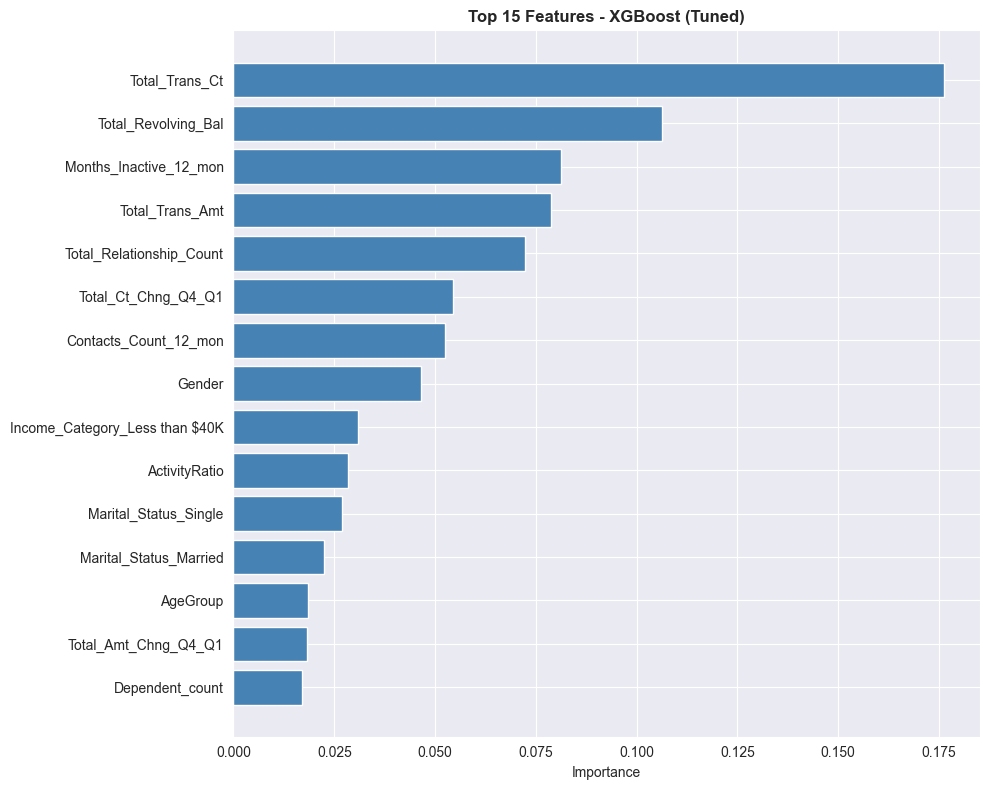

In [22]:
best_model = tuned_models[best_model_name]
importance_df = get_feature_importance(best_model, feature_names, best_model_name)

if importance_df is not None:
    plt.figure(figsize=(10, 8))
    top_15 = importance_df.head(15)

    plt.barh(range(len(top_15)), top_15['Importance'], color='steelblue')
    plt.yticks(range(len(top_15)), top_15['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 15 Features - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('BankChurn2/feature_importance_bank_churners.png', dpi=300, bbox_inches='tight')
    plt.show()

## 11. Confusion Matrix Visualization

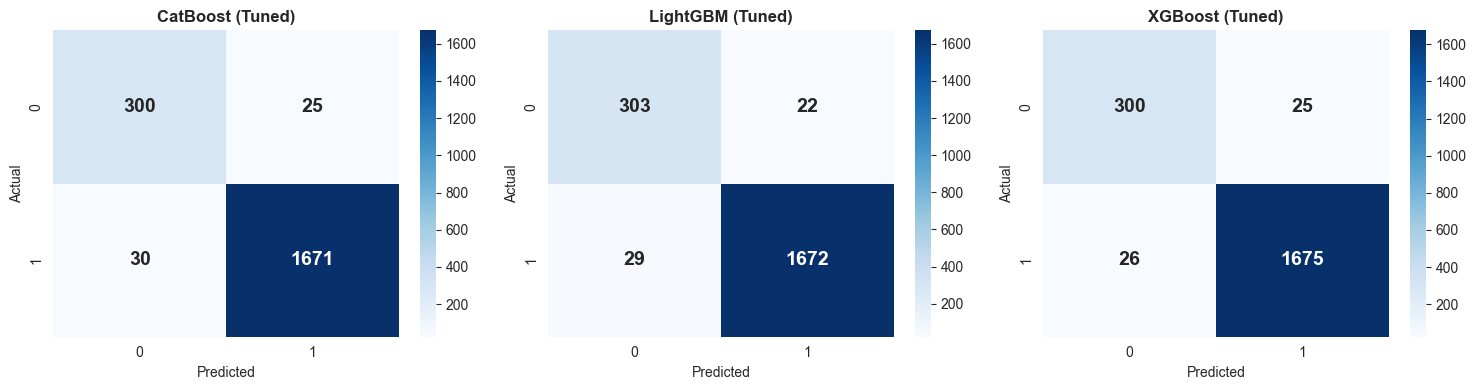

In [23]:
fig, axes = plt.subplots(1, len(tuned_models), figsize=(5 * len(tuned_models), 4))
if len(tuned_models) == 1:
    axes = [axes]

for idx, (name, model) in enumerate(tuned_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                annot_kws={'fontsize': 14, 'fontweight': 'bold'})
    axes[idx].set_title(f'{name}', fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('bankChurn2/confusion_matrices_bank_churners.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Conclusions

In [24]:
print('=' * 70)
print('FINAL SUMMARY')
print('=' * 70)

print('\n1. BEST MODEL:')
print(f'   {best_model_name}')
print(f'   F1-Score: {best_f1:.4f}')
print(f"   Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")

print('\n2. ALL MODELS:')
print(results_df.to_string(index=False))

print('\n3. STATISTICAL SIGNIFICANCE:')
if len(comparisons) > 0 and len(significance_results) > 0:
    if n_bonferroni > 0:
        print(f'   {n_bonferroni} significant difference(s) found')
    else:
        print('   No significant differences - models perform comparably')
else:
    print('   Not enough models for comparison')

print('\n4. TOP 5 FEATURES:')
if importance_df is not None:
    for idx, row in importance_df.head(5).iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.4f}")

print('\n' + '=' * 70)

FINAL SUMMARY

1. BEST MODEL:
   XGBoost (Tuned)
   F1-Score: 0.9850
   Accuracy: 0.9748

2. ALL MODELS:
           Model  Accuracy  Precision   Recall  F1-Score
 XGBoost (Tuned)  0.974827   0.985294 0.984715  0.985004
LightGBM (Tuned)  0.974827   0.987013 0.982951  0.984978
CatBoost (Tuned)  0.972853   0.985259 0.982363  0.983809

3. STATISTICAL SIGNIFICANCE:
   No significant differences - models perform comparably

4. TOP 5 FEATURES:
   Total_Trans_Ct: 0.1764
   Total_Revolving_Bal: 0.1063
   Months_Inactive_12_mon: 0.0812
   Total_Trans_Amt: 0.0789
   Total_Relationship_Count: 0.0722

